# Introduction

Deep learning has recently significantly advanced the state of the art in machine learning. It seems almost like the field has found the magic bullet that can do it all, from face recognition to natural language processing. The goal of this notebook and the following notebooks is to first explain the concepts behind deep learning on an intuitive level with practical tips, enabeling you to get up and running with designing your own deep networks and training them with keras and tensorflow. Second, I am trying to convey a sense of what makes deep learning useful, how to gain insights into what the networks have learned, and last not least what the limitations are and in what cases other classification or regression methods might be a better tool for the job. 

# Logistics
This notebook assumes that you have [keras](https://keras.io/) installed on your system. Keras is a high level deep learning library, which recently became the official high level front end for [tensorflow](https://www.tensorflow.org/). For the purpose of this notebook it is also fine to have the [theano](http://deeplearning.net/software/theano/install.html) backend for keras instead of tensorflow. Under windows I had more success with getting theano to run with GPU support than tensorflow, but these setups might change. Also this notebook uses Python 3.5, because it is the python version supported by tensorflow under windows. If you are under Linux you should have non problem to get either of these libraries to run with python 3.5. 

To make sure that you don't get frustrated by having to install additional packages later on in the notebook, I list all imporant imports here at the beginning in the order they are needed later on. So if you can execute the following cell without any import errors you are ready to go!

In [48]:
# All imports necessary for this notebook

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.initializers import Constant

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning a brief history
TBD

# The perceptron

The perceptron is the basic unit of a deep neural network. As you read above, it caused quite a hype when it was invented, because it can be interpreted as a very simplified model of a neuron. However, we are also going to see that it actually is nothing else than a separating hyperplane, that can be fitted between two point clouds for classification. 

Let's start with the concept of the separating hyperplane. 

<img src="./Figures/DL_SeparatingHyperplane.png" width="25%" height="25%"/>

The figure above shows two point clouds. Each point stands for a sample in our training set. If we find a good position for a separating hyperplane (the green line) between the two point clouds , we can make predictions for other points, that are not part of our training set. If a point lies on the right side of the hyperplane we label it as yellow, if it lies on the left side we label it as blue. We can describe the separating hyperplane with an orthogonal vector $w$ and an offset vector $b$. The vector $w$ describes the orientation of the hyperplane. If we rotate $w$, then the hyperplane rotates as well, because it defined as always being orthogonal to $w$. The vector is called $w$ because we will later see that it describes the weights of the perceptron. The offset vector is used to shift our hyperplane around. The b stands for bias. Training this classifier consists of finding values for $w$ and $b$, that separate the two point clouds. But before we discuss the training, let's think a bit more about how the classification works, once we know the parameters $w$ and $b$. 

For classification of a new data point $x$ we want to determine its estimated label $\hat{y}$. As we can see from the figure above, this means we need to determine if the new point that we want to classifier is on the right or the left side of the hyperplane. All we have to do is evaluate the expression $w^T x + b$ for the new point $x$. If $w^T x + b < 0$ then the point $x$ is on the left side of the hyperplane, so we label it blue. If $w^T x + b > 0$ then it is on the right side of the hyperplane and we label it yellow. For the points directly on the hyperplane we have $w^T x + b = 0$. For these points we need to make an arbitrary decision if we want to label them blue or yellow, because the hyperplane doesn't give us enough information. We could resolve these points by assigning a fixed label, like always label it blue. For a medical application for example, we might want to err on the side of caution and recommend treatment. 

What we have discussed so far, is a very simple linear classifier, but it also can be interpreted as a simplified model of a neuron! Consider the condition for the points on the right side of the hyperplane $w^T x + b > 0$ for a three dimensional point space: Then $x = [x_1, x_2, x_3]^T$, $w = [w_1, w_2, w_3]$, and $b = [b_1]$. So our condition becomes: $w_1 x_1 + w_2 x_2 + w_3 x_3 + b > 0$. We can draw this in a diagram as follows:

<img src="./Figures/DL_Perceptron.png" width="50%" height="50%"/>

In this diagram, each of the input dimensions of $x$ is considered an input to our "neuron". The neuron then multiplies each input with the specific weight from the weight vector $w$. The bias becomes just an extra weight, with the constant input 1. If you compare this to the drawing of a real neuron, we have a dendritic tree, collecting information. The sum sign then corresponds to the cell body, where all the input signal is aggregated. The only aspect missing is to determine if the neuron should "fire"or not, aka the estimated label for $\hat{y}$. To model this last step, we could use a step function, shown in the following figure on the left side:

<img src="./Figures/DL_StepVsSigmoid.png" width="50%" height="50%"/>

As you can see the step function returns zero as long as the sum over the inputs is smaller than zero, so all points to the left of our hyperplane would be mapped to the label zero if we apply this step function to our hyperplane equation $w^T x + b$. If the sum becomes greater than zero, the step function returns one. The problem with the step function though is that it is not continuous and thus doesn't have a derivative. Ultimately, when we train our classifier, we need to compute a gradient to find values for our parameters $w$ and $b$. So instead of using the step function on the left, we can use the sigmoid function $s(z)$ shown on the right side in the figure above. The sigmoid looks approximately like the step function, but is continuous. This function is defined as $s(z) = \frac{1}{1+\exp{-z}}$. You might already know this function because it is also used for logistic regression. If we put all the pieces together now, we have the perceptron computing $\hat{y} = s(w^Tx+b)$. Which actually is the equation for logistic regression and indeed both were invented only two years apart from each other [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) was developed by David Cox in 1958, and the [perceptron](https://en.wikipedia.org/wiki/Perceptron) was developed by Frank Rosenblatt in 1957. 

## Perceptron example

While a single perceptron is not a deep classifier, let's start with getting to know keras a bit and motivate the next theory part about optimization. In this example we will use a perceptron to classify image patches. We will generate two types of 3x3 image patches. One type with a horizontal stripe in the middle, and one with a vertical stripe in the middle. Then we use a perceptron to learn which class a patch belongs to. This setup is very simple and that means we have complete control over it and can learn how the network behaves if we add noise to the patches, etc. So let's get started!

We need to program the following parts:

- a function to generate an image patch for the given class label
- a function to generate our training data
- keras parts to train the classifier
- function to visualize the learned filter

Write a function to generate a 3x3 image patch for a given class label. 

In [2]:
"""
Function
--------
generate_middle_stripe_patch

Given a label, return a 3x3 image patch 
with a line in the middle of the patch. 
The line should be horizontal for label 0 
and vertical for label 1. Background should
be encoded as 0 and the line as 1. 

Inputs
------
label : int
    The label of the image patch to be generated

Returns
-------
patch : 3x3 numpy array
    A patch with a stripe in the middle 
    according to the given label

Example
-------
>>> generate_middle_stripe_patch(0)
array([[ 0.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 0.,  0.,  0.]])
>>> generate_middle_stripe_patch(1)
array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

"""    
#your code here

def generate_middle_stripe_patch(label):
    patch = np.zeros((3,3))
    if label==0:
        patch[1,:] = 1.
    elif label==1:
        patch[:,1] = 1.
    else:
        print("This function is only defined for label==0 or label==1")
    return patch

Now we need a function to generate our training data. In a real world scenario our image patches would contain noise, and would be much harder to classify. To already get familiar with the standard setup for these scenarios, let's generate 100 training samples, although there clearly would be a lot of duplicates and only two really different patches in our training set at this point. 

First write the function:

In [3]:
"""
Function
--------
generate_middle_stripe_data

Given the number of samples, generate a data matrix
number of samples x number of dimensions
and the corresponding label vector

Inputs
------
n_samples : int
    Number of samples for the data matrix

Returns
-------
data : n_samples x 9 numpy array
    A matrix with n_samples rows and each
    row containing the 3x3=9 pixels of an image
    patch
labels : vector of length n_samples
    An array with the class labels corresponding
    to the points in the data matrix

Example
-------
>>> generate_middle_stripe_data(2)
(array([[ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.]]), 
 array([0, 1]))

"""    

def generate_middle_stripe_data(n_samples):
    # generate the labels
    labels = np.random.randint(0,2,n_samples)
    
    # generate corresponding data
    data = np.zeros((n_samples,9))
    for i,l in enumerate(labels):
        patch = generate_middle_stripe_patch(l)
        data[i,:] = patch.flatten()
        
    return (data, labels)

Now generate a training set with 100 samples:

In [4]:
data_train, labels_train = generate_middle_stripe_data(100)

We have all the preparations in place to get started with using keras! Keras has two interfaces: a squential model and a functional API. We will start with the sequential model first, as it is the easier one of the two. If you get more advanced you will need the functional API, but for now the sequential model is really all we need. 

The following lines of code create an empty model first and then add a dense layer with 9 input units and just one ouput unit with a sigmoid activation. We need 9 input units, because our data comes from a 3x3 image patch, so we have 9 pixels in each patch, which means each data point of our training data has 9 dimensions. Compare this with our perceptron figure above. Our $x$ is now 9 dimensional, we still have one bias $b$. The weight vector $w$ has as many dimensions as $x$, so it also has 9 dimensions. We have one "cell body" where all the iputs get summed up. This is the one output unit we have, and then we have the sigmoid activation as a continous approximation of the step function to decide which label we assign to the input data point. 

In [49]:
# create an empty model
model = Sequential()
# add one densely connected unit
model.add(Dense(1, input_dim=9, kernel_initializer=Constant(value=0)))
# add the activation function
model.add(Activation('sigmoid'))

# print a model summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 10        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In the summary above you can see that our model has 10 parameters. These are the 9 weights from the vector $w$ plus the one bias $b$. The sigmoid function doesn't have any parameters, so the number is 0 for this part. 

So we have our model and our training data. All that is left to do is to actually train the model. Training means that we need to find good values for $w$ and $b$ such that our classifier can distinguish the two different image patches. Keras has a number of pre-defined optimizers and loss functions that can be used for this purpose. For now we will just use binary_crossentropy as our loss function and stochastic gradient decent (SGD) as the optimizer to get some results and see some output. Further below you can read about what this loss function and optimizer mean and how they work. 

Training the model consists of two parts in keras. First we need to configure the training process by compiling our model together with the optimizer and the loss function we want to use. After this step comes the actual training with the _fit()_ function. You can see that this function gets the data and the labels as parameters. In addition there is a number of epochs and a batch size defined. The number of epochs specifies how many times the classifier is trained on the whole set of training data. Each iteration over the whole data is split up into smaller batches. So with 100 training samples and a batch size of 10 the network looks at the first 10 samples, trains, looks at 10 more, trains, etc. After 10 steps it has seen all 100 samples and one epoch is finished. 

In [50]:
# compile the model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
model.fit(data_train, labels_train, epochs=5, batch_size=10)

Epoch 1/5
100/100 [==============================] - 0s - loss: 0.6822 - acc: 0.9500     
Epoch 2/5
100/100 [==============================] - 0s - loss: 0.6581 - acc: 1.0000     
Epoch 3/5
100/100 [==============================] - 0s - loss: 0.6354 - acc: 1.0000     
Epoch 4/5
100/100 [==============================] - 0s - loss: 0.6136 - acc: 1.0000     
Epoch 5/5
100/100 [==============================] - 0s - loss: 0.5929 - acc: 1.0000     


Let's look closer at the output from the training. Each iteration outputs something like this:

`Epoch 1/15
100/100 [==============================] - 0s - loss: 0.9685 - acc: 0.4700  `   

The first line shows the current epoch and the maximum number of epochs defined in the _fit()_ function. The second line shows how many samples of the training data have already been looked at in the current epoch and then we get a nice little progress bar and a time estimate how long the current epoch will need to finish. For larger networks this time estimate is especially useful. If you know your network needs 500 iterations to train and each epoch takes a minute, you might want to let it run over night isntead of slowing your computer down during the day. The two remaining values are the current loss and the accuracy on the training data. The loss should go down with training, and the accuracy should go over over time. In our example you can see that the accuracy actually became perfect in the last iterations so our classifier should not do any mistakes now. Let's see if that is true.

In [51]:
# generate a patch for label 0
patch = generate_middle_stripe_patch(0)
patch = patch.reshape(1,9)

#get the prediction from the network
print("Output for patch with label 0: ")
print(model.predict_classes(patch))
print()

# generate a patch for label 1
patch = generate_middle_stripe_patch(1)
patch = patch.reshape(1,9)

#get the prediction from the network
print("Output for patch with label 1: ")
print(model.predict_classes(patch))

Output for patch with label 0: 
1/1 [==============================] - 0s
[[0]]

Output for patch with label 1: 
1/1 [==============================] - 0s
[[1]]


So far so good! Let's see what the learned weights $w$ look like. Remember, the dimensionality of $w$ is the same as the dimensionality of $x$. Our $x$ is a 3x3 image patch, so we can also reshape $w$ as a 3x3 image patch and see what it looks like.

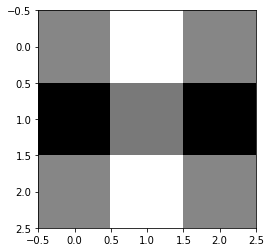

In [52]:
# get the weights from our model
w,b = model.layers[0].get_weights()
w = w.reshape((3,3))

plt.imshow(w, cmap="gray")
plt.show()